## **Project background**

Waze’s data team is working on the churn project. The following tasks are needed at this stage of the project:

* Determine the correct modeling approach

* Build a regression model

* Finish checking model assumptions

* Evaluate the model

* Interpret model results and summarize findings for cross-departmental stakeholders within Waze

**Your assignment**

You will create a regression model for the churn project. You'll determine the type of regression model that is needed and develop one using Waze's churn project data.

## **PACE: Plan**

**Imports and data loading**

In [6]:
# Packages for numerics + dataframes
import pandas as pd
import numpy as np

# Packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Packages for Logistic Regression & Confusion Matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, \
recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

In [7]:
# Load the dataset by running this cell

df = pd.read_csv('waze_dataset.csv')

## **PACE: Analyze**

Some purposes of EDA before constructing a binomial logistic regression model:

> *Outliers and extreme data values can significantly impact logistic
regression models. After visualizing data, make a plan for addressing outliers by dropping rows, substituting extreme data with average data, and/or removing data values greater than 3 standard deviations.*

>  *EDA activities also include identifying missing data to help the analyst make decisions on their exclusion or inclusion by substituting values with dataset means, medians, and other similar methods.*

> *Additionally, it can be useful to create variables by multiplying variables together or calculating the ratio between two variables. For example, in this dataset you can create a drives_sessions_ratio variable by dividing drives by sessions.*

**Explore data with EDA**

Analyze and discover data, looking for correlations, missing data, potential outliers, and/or duplicates.

In [8]:
print(df.shape)

df.info()

(14999, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       14999 non-null  int64  
 1   label                    14299 non-null  object 
 2   sessions                 14999 non-null  int64  
 3   drives                   14999 non-null  int64  
 4   total_sessions           14999 non-null  float64
 5   n_days_after_onboarding  14999 non-null  int64  
 6   total_navigations_fav1   14999 non-null  int64  
 7   total_navigations_fav2   14999 non-null  int64  
 8   driven_km_drives         14999 non-null  float64
 9   duration_minutes_drives  14999 non-null  float64
 10  activity_days            14999 non-null  int64  
 11  driving_days             14999 non-null  int64  
 12  device                   14999 non-null  object 
dtypes: float64(3), int64(8), object(2)
memory usage: 1.5+ MB


The label column is missing 700 values.

In [9]:
df.head()

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android


* I dont't need the ID column so I will remove this information for my analysis.

In [10]:
df = df.drop('ID', axis=1)

* Check the class balance of the dependent (target) variable, `label`.

In [11]:
df['label'].value_counts(normalize=True)

label
retained    0.822645
churned     0.177355
Name: proportion, dtype: float64

In [12]:
df.describe()

,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,80.633776,67.281152,189.964447,1749.837789,121.605974,29.672512,4039.340921,1860.976012,15.537102,12.179879
std,80.699065,65.913872,136.405128,1008.513876,148.121544,45.394651,2502.149334,1446.702288,9.004655,7.824036
min,0.000000,0.000000,0.220211,4.000000,0.000000,0.000000,60.441250,18.282082,0.000000,0.000000
25%,23.000000,20.000000,90.661156,878.000000,9.000000,0.000000,2212.600607,835.996260,8.000000,5.000000
50%,56.000000,48.000000,159.568115,1741.000000,71.000000,9.000000,3493.858085,1478.249859,16.000000,12.000000
75%,112.000000,93.000000,254.192341,2623.500000,178.000000,43.000000,5289.861262,2464.362632,23.000000,19.000000
max,743.000000,596.000000,1216.154633,3500.000000,1236.000000,415.000000,21183.401890,15851.727160,31.000000,30.000000


> *The following columns all seem to have outliers:*
<br>
* `sessions`
* `drives`
* `total_sessions`
* `total_navigations_fav1`
* `total_navigations_fav2`
* `driven_km_drives`
* `duration_minutes_drives`


> *All of these columns have max values that are multiple standard deviations above the 75th percentile. This could indicate outliers in these variables.*

**Create features**

Create features that may be of interest to the stakeholder and/or that are needed to address the business scenario/problem.

#### **`km_per_driving_day`**

In [13]:
# 1. Create `km_per_driving_day` column
df['km_per_driving_day'] = df['driven_km_drives'] / df['driving_days']

# 2. Call `describe()` on the new column
df['km_per_driving_day'].describe()

count    1.499900e+04
mean              inf
std               NaN
min      3.022063e+00
25%      1.672804e+02
50%      3.231459e+02
75%      7.579257e+02
max               inf
Name: km_per_driving_day, dtype: float64

In [14]:
# 1. Convert infinite values to zero
df.loc[df['km_per_driving_day']==np.inf, 'km_per_driving_day'] = 0

# 2. Confirm that it worked
df['km_per_driving_day'].describe()

count    14999.000000
mean       578.963113
std       1030.094384
min          0.000000
25%        136.238895
50%        272.889272
75%        558.686918
max      15420.234110
Name: km_per_driving_day, dtype: float64

#### **`professional_driver`**

In [15]:
# Create `professional_driver` column
df['professional_driver'] = np.where((df['drives'] >= 60) & (df['driving_days'] >= 15), 1, 0)

In [16]:
# 1. Check count of professionals and non-professionals
print(df['professional_driver'].value_counts())

# 2. Check in-class churn rate
df.groupby(['professional_driver'])['label'].value_counts(normalize=True)

professional_driver
0    12405
1     2594
Name: count, dtype: int64


professional_driver  label   
0                    retained    0.801202
                     churned     0.198798
1                    retained    0.924437
                     churned     0.075563
Name: proportion, dtype: float64

* The churn rate for professional drivers is 7.6%, while the churn rate for non-professionals is 19.9%. This seems like it could add predictive signal to the model.

## **PACE: Construct**

Select the X variables:
> *Initially, columns were dropped based on high multicollinearity. Later, variable selection can be fine-tuned by running and rerunning models to look at changes in accuracy, recall, and precision.*
<br></br>
> *Initial variable selection was based on the business objective and insights from prior EDA.*

**Preparing variables**

Call info() on the dataframe to check the data type of the label variable and to verify if there are any missing values.

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   label                    14299 non-null  object 
 1   sessions                 14999 non-null  int64  
 2   drives                   14999 non-null  int64  
 3   total_sessions           14999 non-null  float64
 4   n_days_after_onboarding  14999 non-null  int64  
 5   total_navigations_fav1   14999 non-null  int64  
 6   total_navigations_fav2   14999 non-null  int64  
 7   driven_km_drives         14999 non-null  float64
 8   duration_minutes_drives  14999 non-null  float64
 9   activity_days            14999 non-null  int64  
 10  driving_days             14999 non-null  int64  
 11  device                   14999 non-null  object 
 12  km_per_driving_day       14999 non-null  float64
 13  professional_driver      14999 non-null  int32  
dtypes: float64(4), int32(1

In [18]:
# Drop rows with missing data in `label` column
df = df.dropna(subset=['label'])

**Impute outliers**

For this analysis, impute the outlying values for these columns. Calculate the **95th percentile** of each column and change to this value any value in the column that exceeds it.


In [27]:
# Impute outliers
for column in ['sessions', 'drives', 'total_sessions', 'total_navigations_fav1',
               'total_navigations_fav2', 'driven_km_drives', 'duration_minutes_drives']:
    if column in df.columns:
        threshold = df[column].quantile(0.95)
        df.loc[df[column] > threshold, column] = threshold

In [28]:
df.describe()

,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,km_per_driving_day,professional_driver,label2
count,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000,14299.000000
mean,76.539688,63.964683,183.716684,1751.822505,114.562767,27.187216,3944.556469,1792.907697,15.544653,12.182530,581.942399,0.173998,0.177355
std,67.243178,55.127927,118.719101,1008.663834,124.378550,36.715302,2218.353431,1224.321508,9.016088,7.833835,1038.254509,0.379121,0.381982
min,0.000000,0.000000,0.220211,4.000000,0.000000,0.000000,60.441250,18.282082,0.000000,0.000000,0.000000,0.000000,0.000000
25%,23.000000,20.000000,90.457733,878.500000,10.000000,0.000000,2217.319909,840.181344,8.000000,5.000000,136.168003,0.000000,0.000000
50%,56.000000,48.000000,158.718571,1749.000000,71.000000,9.000000,3496.545617,1479.394387,16.000000,12.000000,273.301012,0.000000,0.000000
75%,111.000000,93.000000,253.540450,2627.500000,178.000000,43.000000,5299.972162,2466.928876,23.000000,19.000000,558.018761,0.000000,0.000000
max,243.000000,200.000000,455.427095,3500.000000,422.000000,124.000000,8898.673053,4668.109828,31.000000,30.000000,15420.234110,1.000000,1.000000


**Encode categorical variables**

Change the data type of the `label` column to be binary. This change is needed to train a logistic regression model.

Assign a `0` for all `retained` users.

Assign a `1` for all `churned` users.

Save this variable as `label2` as to not overwrite the original `label` variable.

In [29]:
# Create binary `label2` column
df['label2'] = np.where(df['label']=='churned', 1, 0)
df[['label', 'label2']].tail()

,label,label2
14994,retained,0
14995,retained,0
14996,retained,0
14997,churned,1
14998,retained,0


**Determine whether assumptions have been met**

**Collinearity**
<br>
Check the correlation among predictor variables. First, generate a correlation matrix.

In [34]:
df_numeric = df.select_dtypes(include=[float, int])
df_numeric = df_numeric.fillna(df_numeric.mean())

In [37]:
# Generate a correlation matrix
corr_matrix = df_numeric.corr(method='pearson')
corr_matrix

,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,km_per_driving_day,professional_driver,label2
sessions,1.000000,0.996942,0.597190,0.007101,0.001858,0.008536,0.002996,-0.004545,0.025113,0.020294,-0.011569,0.443654,0.034911
drives,0.996942,1.000000,0.595286,0.006940,0.001058,0.009505,0.003445,-0.003889,0.024357,0.019608,-0.010989,0.444425,0.035865
total_sessions,0.597190,0.595286,1.000000,0.006596,0.000187,0.010371,0.001016,-0.000338,0.015755,0.012953,-0.016167,0.254434,0.024568
n_days_after_onboarding,0.007101,0.006940,0.006596,1.000000,-0.002450,-0.004968,-0.004652,-0.010167,-0.009418,-0.007321,0.011764,0.003770,-0.129263
total_navigations_fav1,0.001858,0.001058,0.000187,-0.002450,1.000000,0.002866,-0.007368,0.005646,0.010902,0.010419,-0.000197,-0.000224,0.052322
total_navigations_fav2,0.008536,0.009505,0.010371,-0.004968,0.002866,1.000000,0.003559,-0.003009,-0.004425,0.002000,0.006751,0.007126,0.015032
driven_km_drives,0.002996,0.003445,0.001016,-0.004652,-0.007368,0.003559,1.000000,0.690514,-0.007441,-0.009549,0.344811,-0.000904,0.019767
duration_minutes_drives,-0.004545,-0.003889,-0.000338,-0.010167,0.005646,-0.003009,0.690514,1.000000,-0.007895,-0.009426,0.239627,-0.012128,0.040407
activity_days,0.025113,0.024357,0.015755,-0.009418,0.010902,-0.004425,-0.007441,-0.007895,1.000000,0.947687,-0.397433,0.453825,-0.303851
driving_days,0.020294,0.019608,0.012953,-0.007321,0.010419,0.002000,-0.009549,-0.009426,0.947687,1.000000,-0.407917,0.469776,-0.294259


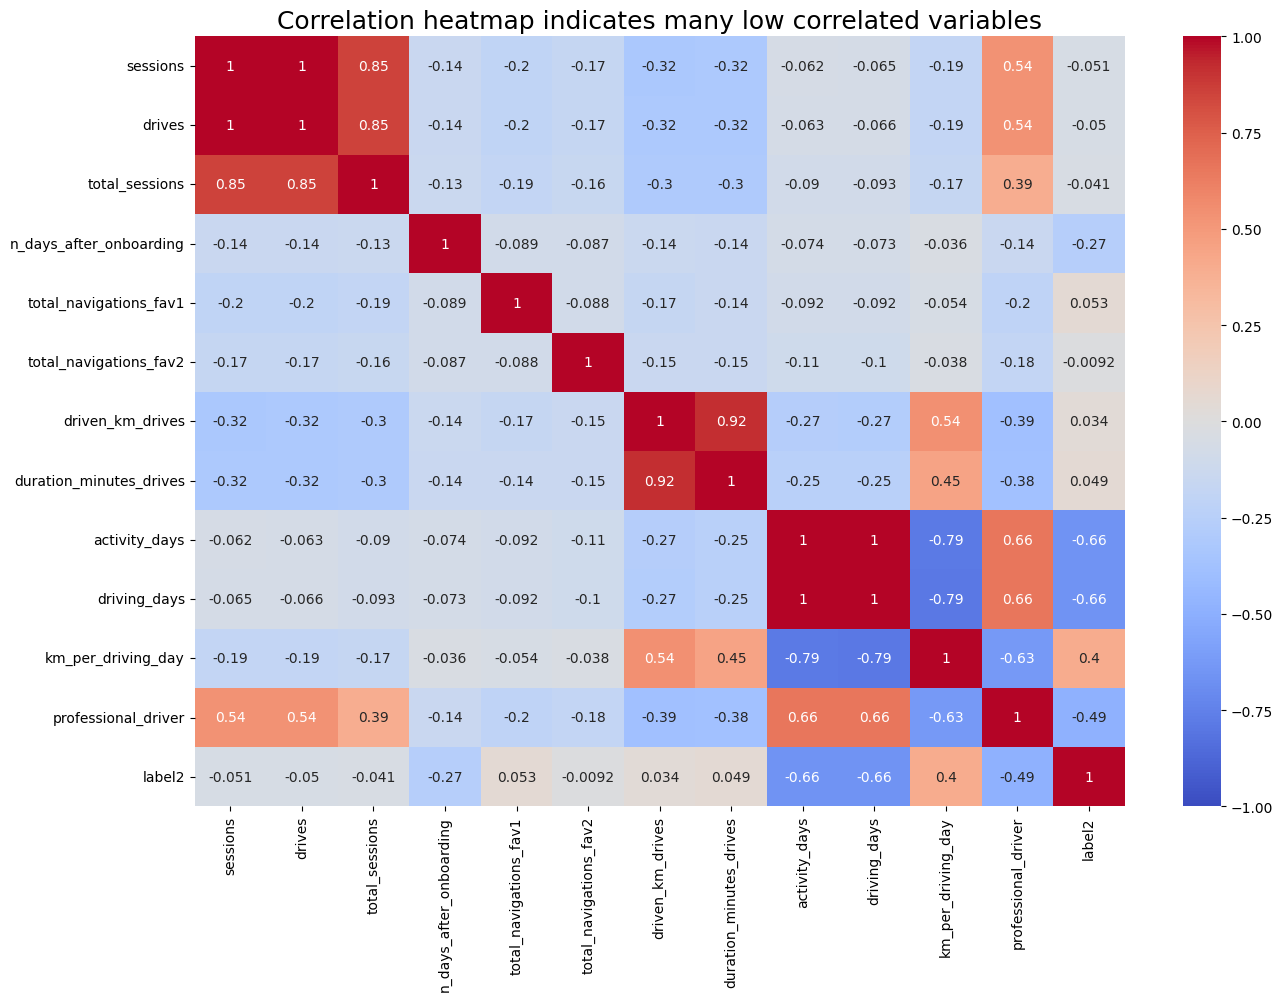

In [39]:
# Plot correlation heatmap
plt.figure(figsize=(15,10))
sns.heatmap(corr_matrix.corr(method='pearson'), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
plt.title('Correlation heatmap indicates many low correlated variables',
          fontsize=18)
plt.show()

Variables are multicollinear with each other:

> * *`sessions` and `drives`: 1.0*
<br>
> * *`driving_days` and `activity_days`: 0.95*

**Create dummies**

In [40]:
# Create new `device2` variable
df['device2'] = np.where(df['device']=='Android', 0, 1)
df[['device', 'device2']].tail()

,device,device2
14994,iPhone,1
14995,Android,0
14996,iPhone,1
14997,iPhone,1
14998,iPhone,1


**Model building**

In [41]:
# Isolate predictor variables
X = df.drop(columns = ['label', 'label2', 'device', 'sessions', 'driving_days'])

In [42]:
# Isolate target variable
y = df['label2']

**Split the data**

In [43]:
# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [44]:
# Use .head()
X_train.head()

,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,km_per_driving_day,professional_driver,device2
152,108,186.192746,3116,243,124,8898.673053,4668.109828,24,612.305861,1,1
11899,2,3.487590,794,114,18,3286.545691,1780.902733,5,3286.545691,0,1
10937,139,347.106403,331,4,7,7400.838975,2349.305267,15,616.736581,0,0
669,108,455.427095,2320,11,4,6566.424830,4558.459870,18,410.401552,1,1
8406,10,89.475821,2478,135,0,1271.248661,938.711572,27,74.779333,0,1


In [47]:
model = LogisticRegression(penalty= None, max_iter=400)

model.fit(X_train, y_train)

c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=400, penalty=None)

Call the `.coef_` attribute on the model to get the coefficients of each variable.  The coefficients are in order of how the variables are listed in the dataset.  Remember that the coefficients represent the change in the **log odds** of the target variable for **every one unit increase in X**.

Create a series whose index is the column names and whose values are the coefficients in `model.coef_`.

In [48]:
pd.Series(model.coef_[0], index=X.columns)

drives                     0.001941
total_sessions             0.000359
n_days_after_onboarding   -0.000401
total_navigations_fav1     0.001252
total_navigations_fav2     0.000991
driven_km_drives          -0.000013
duration_minutes_drives    0.000110
activity_days             -0.105325
km_per_driving_day         0.000019
professional_driver       -0.007539
device2                    0.022966
dtype: float64

Call the model's intercept_ attribute to get the intercept of the model.

In [49]:
model.intercept_

array([-0.05790242])

**Check final assumption**

In [50]:
# Get the predicted probabilities of the training data
training_probabilities = model.predict_proba(X_train)
training_probabilities

array([[0.9374245 , 0.0625755 ],
       [0.62187963, 0.37812037],
       [0.76666396, 0.23333604],
       ...,
       [0.91809091, 0.08190909],
       [0.84885917, 0.15114083],
       [0.93334996, 0.06665004]])

In [51]:
# 1. Copy the `X_train` dataframe and assign to `logit_data`
logit_data = X_train.copy()

# 2. Create a new `logit` column in the `logit_data` df
logit_data['logit'] = [np.log(prob[1] / prob[0]) for prob in training_probabilities]

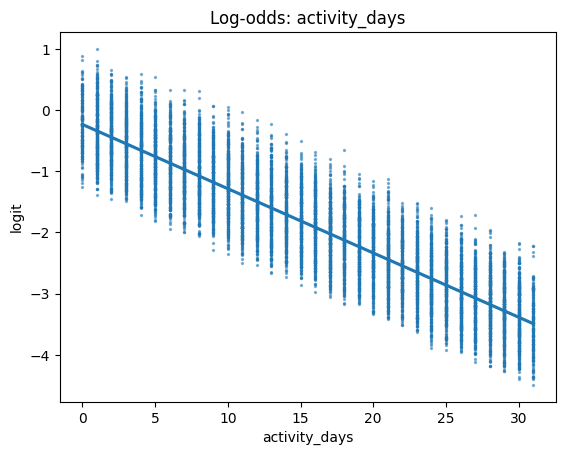

In [52]:
# Plot regplot of `activity_days` log-odds
sns.regplot(x='activity_days', y='logit', data=logit_data, scatter_kws={'s': 2, 'alpha': 0.5})
plt.title('Log-odds: activity_days');

## **PACE: Execute**

**Results and evaluation**

In [53]:
# Generate predictions on X_test
y_preds = model.predict(X_test)

In [54]:
# Score the model (accuracy) on the test data
model.score(X_test, y_test)

0.8243356643356643

**Show results with a confusion matrix**

Use the confusion_matrix function to obtain a confusion matrix. Use y_test and y_preds as arguments.

In [55]:
cm = confusion_matrix(y_test, y_preds)

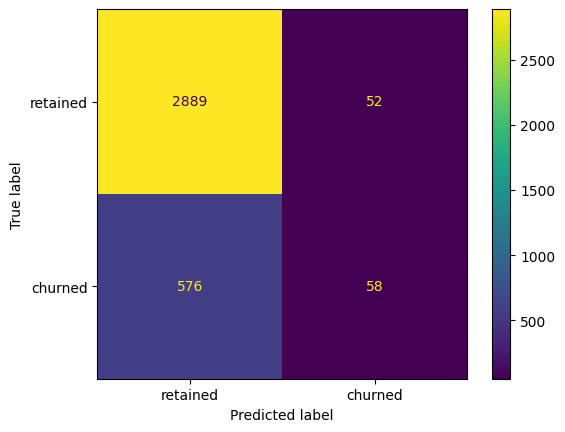

In [56]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=['retained', 'churned'],
                              )
disp.plot();

In [57]:
# Calculate precision manually
precision = cm[1,1] / (cm[0, 1] + cm[1, 1])
precision

0.5272727272727272

In [58]:
# Calculate recall manually
recall = cm[1,1] / (cm[1, 0] + cm[1, 1])
recall

0.0914826498422713

In [59]:
# Create a classification report
target_labels = ['retained', 'churned']
print(classification_report(y_test, y_preds, target_names=target_labels))

              precision    recall  f1-score   support

    retained       0.83      0.98      0.90      2941
     churned       0.53      0.09      0.16       634

    accuracy                           0.82      3575
   macro avg       0.68      0.54      0.53      3575
weighted avg       0.78      0.82      0.77      3575



Generate a bar graph of the model's coefficients for a visual representation of the importance of the model's features.

In [60]:
# Create a list of (column_name, coefficient) tuples
feature_importance = list(zip(X_train.columns, model.coef_[0]))

# Sort the list by coefficient value
feature_importance = sorted(feature_importance, key=lambda x: x[1], reverse=True)
feature_importance

[('device2', 0.02296558735953105),
 ('drives', 0.001940634772148316),
 ('total_navigations_fav1', 0.0012518821673695598),
 ('total_navigations_fav2', 0.0009913696507206457),
 ('total_sessions', 0.0003586428157310157),
 ('duration_minutes_drives', 0.00010999735012749019),
 ('km_per_driving_day', 1.9316040863580253e-05),
 ('driven_km_drives', -1.2899363045674138e-05),
 ('n_days_after_onboarding', -0.000401317367651491),
 ('professional_driver', -0.0075393013093202526),
 ('activity_days', -0.10532514696798714)]

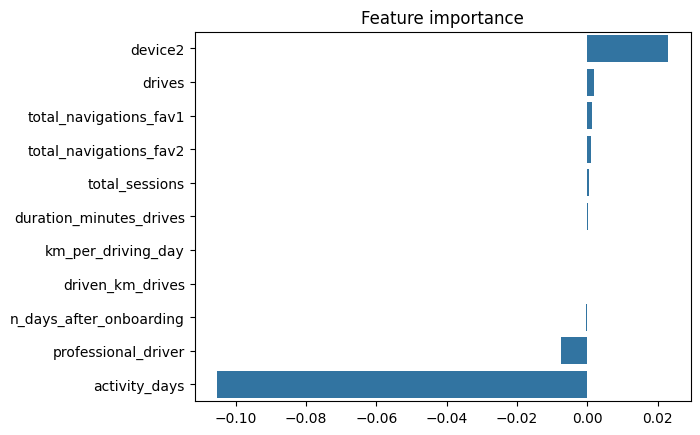

In [61]:
# Plot the feature importances
import seaborn as sns
sns.barplot(x=[x[1] for x in feature_importance],
            y=[x[0] for x in feature_importance],
            orient='h')
plt.title('Feature importance');

**Conclusion**

1. What variable most influenced the model's prediction? How? Was this surprising?

> _`activity_days` was by far the most important feature in the model. It had a negative correlation with user churn. This was not surprising, as this variable was very strongly correlated with `driving_days`, which was known from EDA to have a negative correlation with churn._

2. Were there any variables that you expected to be stronger predictors than they were?

> _Yes. In previous EDA, user churn rate increased as the values in `km_per_driving_day` increased. The correlation heatmap here in this notebook revealed this variable to have the strongest positive correlation with churn of any of the predictor variables by a relatively large margin. In the model, it was the second-least-important variable._

3. Why might a variable you thought to be important not be important in the model?

> _In a multiple logistic regression model, features can interact with each other and these interactions can result in seemingly counterintuitive relationships. This is both a strength and a weakness of predictive models, as capturing these interactions typically makes a model more predictive while at the same time making the model more difficult to explain._

4. Would you recommend that Waze use this model? Why or why not?

> _It depends. What would the model be used for? If it's used to drive consequential business decisions, then no. The model is not a strong enough predictor, as made clear by its poor recall score. However, if the model is only being used to guide further exploratory efforts, then it can have value._

5. What could you do to improve this model?

> _New features could be engineered to try to generate better predictive signal, as they often do if you have domain knowledge. In the case of this model, one of the engineered features (`professional_driver`) was the third-most-predictive predictor. It could also be helpful to scale the predictor variables, and/or to reconstruct the model with different combinations of predictor variables to reduce noise from unpredictive features._

6. What additional features would you like to have to help improve the model?

> _It would be helpful to have drive-level information for each user (such as drive times, geographic locations, etc.). It would probably also be helpful to have more granular data to know how users interact with the app. For example, how often do they report or confirm road hazard alerts? Finally, it could be helpful to know the monthly count of unique starting and ending locations each driver inputs._